## Time series Example

Can we predict the next-month average electricity consumption using green energy production?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We are going to use the Open Power System Data, containing electricity consumption and production values from 2007 to 2017.  
The dataset offers three covariates:
* _Consumption_: Electricity consumption.  
* _Wind_: Wind energy production.  
* _Solar_: Solar energy production.  

Plus a combination of the last two, _Wind+Solar_.  
The dataset contains daily reports, but for simplicty we will resample the daily data to monthly averages.

In [2]:
# Let's download the publicly available dataset Open Power System Data
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")

In [3]:
# quick preprocessing, converting Date to datetime
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')
data

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


In [4]:
# monthly resampling 
y = data.resample('M').mean().Consumption[1:] # creating outcomes
X = data.resample('M').mean().iloc[:-1,:] # covariates
groups = np.arange(y.shape[0]) # assigning a numeric value to each date

To assess the goodness of our model we will use __WalkForwardCV__, which spllits data so that test data is always ahead in time compared to train data.

In [5]:
# Preserving crossvalidation consequentiality with WalkForwardCV
from jhn_ai.crossvalidators import WalkForwardCV

cv = WalkForwardCV(min_train_size = 3, max_train_size = 24, 
                   gap = 0, test_size = 1, step = 1)
# we are testing out model predicting 1 month ahead trained with data from at-most the past 24 months.
# we also say that we want our model to be trained with at least 3 months of data.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline 
from sklearn.dummy import DummyRegressor
from jhn_ai.transformers import ColinearityRemover, RateImputer


# let's create a simple linear regression estimator
model = Pipeline([
    ('imputing', RateImputer()),
    ('scaling', StandardScaler()),
    ('linear_fs', ColinearityRemover()),
    ('estimator', Ridge(random_state = 0))
])

C:\Users\giovi\OneDrive\Documenti\Python Scripts\releases\jhn_ai\jhn_ai\transformers.py:147: UserWarning: RateImputer will be deprecated
  warn("RateImputer will be deprecated")


To perform crossvalidation we can use __supervised_crossvalidation__ out of the box, it will return all the metrics we need to assess the model.

In [7]:
from jhn_ai.evaluation import supervised_crossvalidation


scores, _, _, cv_fi, fold_maps = supervised_crossvalidation(model, X, y, groups = groups, cv = cv)

# let'salso compute a baseline so to compare the goodness of our model
baseline = DummyRegressor(strategy = 'mean')
baseline_scores, _, _, _, _ = supervised_crossvalidation(baseline, X, y, groups = groups, cv = cv)


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:01<00:00, 76.02it/s]


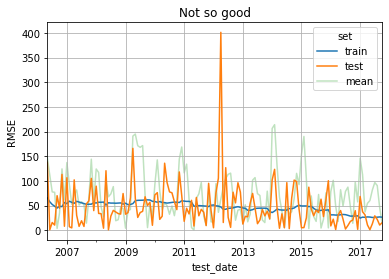

In [8]:
rmse = scores.query("metric == 'root_mean_squared_error'").droplevel(1)
baseline_rmse = baseline_scores.query("metric == 'root_mean_squared_error'").droplevel(1)

# with fold_maps we can re-obtain the dataset dates from the crossvalidation indexes.
#each fold in fold_map is a dictionary containing the index usedfro train and test in that fold.
rmse['test_date'] = np.array([fold['test'] for fold in fold_maps])
baseline_rmse['test_date'] = np.array([fold['test'] for fold in fold_maps])

ax = rmse.plot(x = 'test_date', y = ['train','test']
               , title = 'Not so good', ylabel = 'RMSE')
_ = baseline_rmse.plot(x = 'test_date', y = 'test', ax = ax, 
                       label = 'mean', alpha = .3, zorder = -1, grid = .3)

To improve the performance of the model we may try add more features and see what happens.  
We will re-run __supervied_crossvalidation__ with the new model to see how it performs.

In [9]:
# let's try to add the approximate current seasonality in the dataset
season_map = {}
[season_map.update({month: month%12 // 3 + 1}) for month in range(1, 13)]
dummy_seasons = pd.get_dummies(pd.Series(X.index.month, index = X.index).replace(season_map)).rename(columns = {1:'Winter',2:'Spring',3:'Summer',4:'Fall'})
X_w_seasons = pd.concat([X, dummy_seasons], axis = 1)

In [10]:
X_w_seasons

,Consumption,Wind,Solar,Wind+Solar,Winter,Spring,Summer,Fall
Date,,,,,,,,
2006-01-31,1461.442065,NaN,NaN,NaN,1,0,0,0
2006-02-28,1467.106893,NaN,NaN,NaN,1,0,0,0
2006-03-31,1418.649161,NaN,NaN,NaN,0,1,0,0
2006-04-30,1275.058900,NaN,NaN,NaN,0,1,0,0
2006-05-31,1253.488484,NaN,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...
2017-07-31,1287.341226,177.210452,157.624484,334.834935,0,0,1,0
2017-08-31,1291.283022,177.412839,148.477677,325.890516,0,0,1,0
2017-09-30,1335.952031,209.591000,102.643033,312.234033,0,0,0,1


__supervised_crossvalidation__ also supports _collect func_, which is a user defined callable that can access the model parameters _dynamically_ during runtime.

100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:04<00:00, 31.75it/s]


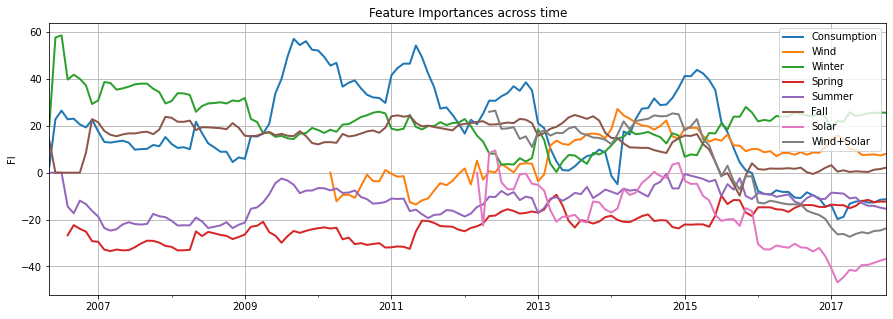

In [11]:
# let's see how it behaves now
features = X_w_seasons.columns.values

def get_fi(model): 
    # collect_func expectes a sklearn-like trained model.
    # get_fi returns the features selected by the model after each fold with their importances.
    feat = features
    #I love walrus
    return  pd.Series(model[-1].coef_, index = [feat:=feat[obj.get_support()] for obj in model if hasattr(obj, 'get_support')][-1])

scores, _, _, cv_fi, fold_maps = supervised_crossvalidation(model, X_w_seasons, y, groups = groups, cv = cv,
                                               collect_func =  get_fi)

# cv_fi contains sleected features with their weight in each fold
fi_across_folds = pd.concat(cv_fi, axis = 1)
fi_across_folds.columns = np.array([fold['test'][0] for fold in fold_maps])
_ = fi_across_folds.T.plot(figsize = (15, 5), grid = .3, ylabel = 'FI', lw = 2, title = 'Feature Importances across time')

with _collect_func_ and __supervised_crossvalidation__ it is possible ti dynamically inspect model behaviors durig crossvalidation.  
Above you can see that, before 2009 our model greatly considers Winter as the main predictor of electricity consumption. Afterwards, past consumption is the best predictior. Finally, after 2013, it's more or less a blend of all available features.  
_collect_func_ may be used in several ways, such us improve models interpretability, troubleshooting and refactoring. 

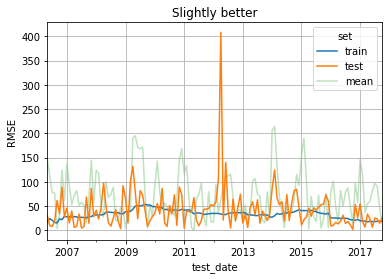

In [12]:
# we can rerun the code from above to see the model performance
rmse_with_seasons = scores.query("metric == 'root_mean_squared_error'").droplevel(1)
baseline_rmse = baseline_scores.query("metric == 'root_mean_squared_error'").droplevel(1)

rmse_with_seasons['test_date'] = np.array([fold['test'] for fold in fold_maps])
baseline_rmse['test_date'] = np.array([fold['test'] for fold in fold_maps])

ax = rmse_with_seasons.plot(x = 'test_date', y = ['train','test']
               , title = 'Slightly better', ylabel = 'RMSE')
_ = baseline_rmse.plot(x = 'test_date', y = 'test', ax = ax, 
                       label = 'mean', alpha = .3, zorder = -1, grid = .3)

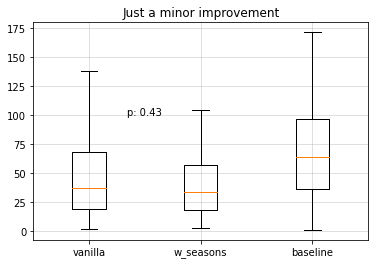

In [13]:
from scipy.stats import mannwhitneyu
# does the season model looks better or is actually better?
_, p = mannwhitneyu(rmse.test.values, rmse_with_seasons.test.values)

fig, ax = plt.subplots()
_ = ax.boxplot([rmse.test.values, rmse_with_seasons.test.values, baseline_rmse.test.values], showfliers = False)
_ = ax.set_xticklabels(['vanilla','w_seasons','baseline'])
_ = ax.grid(alpha = .5)
_ = ax.text(1.5, 100, f'p: {p:.2f}', ha = 'center')
_ = ax.set_title('Just a minor improvement')

Regardless of the goodness of the model, with few lines of code jhn_ai enables to accurately compare model performances during cross-validation.